In [ ]:
!pip install transformers datasets torch torchvision pillow tqdm evaluate rouge_score

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.5 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=143dcfe5641543fd876837870e47aa0b6af0f2bd3a60aba15dbb8f7377b4f0fb
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import os
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_dataset, DatasetDict
from PIL import Image
from torchvision.transforms import ToTensor
import evaluate
from torch.utils.data import DataLoader
import numpy as np
from transformers import DataCollatorForSeq2Seq

In [ ]:
# -------------------------------
# Configuration Parameters
# -------------------------------
DATASET_NAME = "tomytjandra/h-and-m-fashion-caption-12k"  # Replace with your dataset name or path
MODEL_NAME = "Salesforce/blip-image-captioning-base"  # Pre-trained BLIP model
OUTPUT_DIR = "/content/drive/MyDrive/BLIP"  # Directory to save the fine-tuned model
BATCH_SIZE = 8  # Adjust based on your GPU memory
EPOCHS = 3
LEARNING_RATE = 5e-5
MAX_LENGTH = 224  # Maximum length of generated captions
SEED = 42
USE_GPU = torch.cuda.is_available()
TEST_SPLIT_PERCENTAGE = 20

torch.manual_seed(SEED)
if USE_GPU:
    torch.cuda.manual_seed_all(SEED)

In [ ]:
# -------------------------------
# Load the Dataset
# -------------------------------
# Replace 'your_dataset_name' with your actual dataset name or local path
dataset = load_dataset(DATASET_NAME)

# -------------------------------
# Load BLIP Model and Processor
# -------------------------------
processor = BlipProcessor.from_pretrained(MODEL_NAME)
model = BlipForConditionalGeneration.from_pretrained(MODEL_NAME)

# Move model to GPU if available
device = torch.device("cuda" if USE_GPU else "cpu")
# Freeze the encoder
# Freeze the image encoder
image_encoder = model.vision_model
for param in image_encoder.parameters():
    param.requires_grad = False

model.to(device)

embeddings.class_embedding: requires_grad=False
embeddings.position_embedding: requires_grad=False
embeddings.patch_embedding.weight: requires_grad=False
embeddings.patch_embedding.bias: requires_grad=False
encoder.layers.0.self_attn.qkv.weight: requires_grad=False
encoder.layers.0.self_attn.qkv.bias: requires_grad=False
encoder.layers.0.self_attn.projection.weight: requires_grad=False
encoder.layers.0.self_attn.projection.bias: requires_grad=False
encoder.layers.0.layer_norm1.weight: requires_grad=False
encoder.layers.0.layer_norm1.bias: requires_grad=False
encoder.layers.0.mlp.fc1.weight: requires_grad=False
encoder.layers.0.mlp.fc1.bias: requires_grad=False
encoder.layers.0.mlp.fc2.weight: requires_grad=False
encoder.layers.0.mlp.fc2.bias: requires_grad=False
encoder.layers.0.layer_norm2.weight: requires_grad=False
encoder.layers.0.layer_norm2.bias: requires_grad=False
encoder.layers.1.self_attn.qkv.weight: requires_grad=False
encoder.layers.1.self_attn.qkv.bias: requires_grad=False

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

(array([ 285., 1042., 1949., 2292., 2256., 1939., 1560.,  891.,  206.,
          17.]),
 array([ 60. ,  83.4, 106.8, 130.2, 153.6, 177. , 200.4, 223.8, 247.2,
        270.6, 294. ]),
 <BarContainer object of 10 artists>)

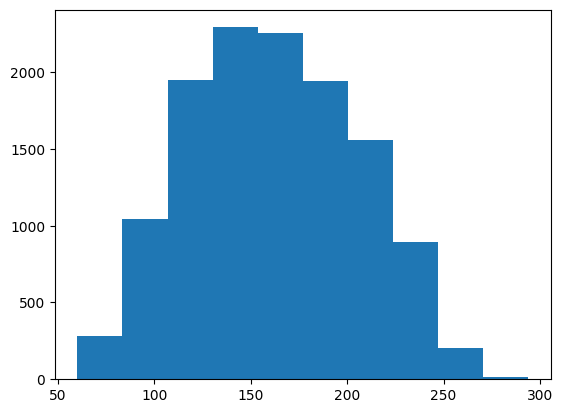

In [ ]:
import matplotlib.pyplot as plt

check = []
for cp in dataset['train']['text']:
  check.append(len(cp))

plt.hist(check, bins = 10)

In [ ]:
max(check)

294

In [ ]:
def preprocess_function(examples):
    # Process images
    images = []
    for img in examples['image']:
        images.append(img.convert("RGB"))

    # Tokenize captions
    inputs = processor(images=images, text=examples['text'],
                      max_length=MAX_LENGTH, padding="max_length", truncation=True)

    # Assign labels (copy of input_ids)
    inputs["labels"] = inputs["input_ids"].copy()

    return inputs

In [ ]:
split_dataset = dataset['train'].train_test_split(test_size=TEST_SPLIT_PERCENTAGE / 100, seed=42)
print("\nSplit Dataset Structure:")
print(split_dataset)

# Assign splits
train_dataset = split_dataset['train']
test_dataset = split_dataset['test']

# -------------------------------
# Apply Preprocessing to Dataset
# -------------------------------
print("\nPreprocessing the training data...")
tokenized_train = train_dataset.map(preprocess_function, batched=True, batch_size = BATCH_SIZE, remove_columns=dataset['train'].column_names)


Split Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'image'],
        num_rows: 9949
    })
    test: Dataset({
        features: ['text', 'image'],
        num_rows: 2488
    })
})

Preprocessing the training data...


Map:   0%|          | 0/9949 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorForSeq2Seq(processor.tokenizer, model=model)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=EPOCHS,
    predict_with_generate=True,
    fp16=True,  # Enable mixed precision if using GPU
    logging_dir='./logs',
    logging_steps=10,
    seed=SEED,
    gradient_accumulation_steps=8
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    # If you have a validation set, you can pass it here using eval_dataset
    # eval_dataset=tokenized_validation,
    tokenizer=processor.tokenizer,
    data_collator=data_collator,
    # compute_metrics=compute_metrics,
)

# -------------------------------
# Fine-Tune the Model
# -------------------------------
print("\nStarting fine-tuning...")
trainer.train()

# -------------------------------
# Save the Fine-Tuned Model
# -------------------------------
print(f"\nSaving the fine-tuned model to {OUTPUT_DIR}...")
trainer.save_model(OUTPUT_DIR)
processor.save_pretrained(OUTPUT_DIR)
print("Model saved successfully!")

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)



Starting fine-tuning...


Epoch,Training Loss,Validation Loss


Exception ignored in: <function _xla_gc_callback at 0x78f9f29a3490>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x78f9f29a3490>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
Exception ignored in: <function _xla_gc_callback at 0x78f9f29a3490>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# Define evaluation metrics
bleu = evaluate.load("bleu")
meteor = evaluate.load("meteor")
rouge = evaluate.load("rouge")
cider = evaluate.load("cider")

# -------------------------------
# Define Compute Metrics Function
# -------------------------------
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = processor.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in labels as we can't decode them
    labels = np.where(labels != -100, labels, processor.tokenizer.pad_token_id)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)

    # References should be a list of list of references
    references = [[label] for label in decoded_labels]
    predictions = decoded_preds

    # Compute metrics
    bleu_result = bleu.compute(predictions=predictions, references=references)
    meteor_result = meteor.compute(predictions=predictions, references=references)
    rouge_result = rouge.compute(predictions=predictions, references=references)
    cider_result = cider.compute(predictions=predictions, references=references)

    return {
        "bleu": bleu_result["bleu"],
        "meteor": meteor_result["meteor"],
        "rouge1": rouge_result["rouge1"],
        "rouge2": rouge_result["rouge2"],
        "rougeL": rouge_result["rougeL"],
        "cider": cider_result["cider"],
    }